###### Kode rujukan : https://github.com/AryanSethi/No-Blur

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import cv2
import time
from tensorflow.keras.utils import Sequence
import datetime
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# from keras.preprocessing import image
# import glob
# from tqdm import tqdm
# import warnings;
# warnings.filterwarnings('ignore')

In [2]:
def convert_bgr_to_rgb(img):
    return cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)

# Data load & Preprocessing

In [21]:
class DataGenerator(Sequence):

  def __init__(self, base_dir,base_dir2, output_size, shuffle=False, batch_size=10):
    self.base_dir = base_dir
    self.base_dir2 = base_dir2
    self.output_size = output_size
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.all_x = os.listdir(base_dir)
    self.all_y = os.listdir(base_dir2)
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indices = np.arange(len(self.all_x))
    if self.shuffle:
      np.random.shuffle(self.indices)

  def __len__(self):
    return int(len(self.all_x) / self.batch_size)

  def __getitem__(self, idx):
    X = np.empty((self.batch_size, *self.output_size, 3))
    Y = np.empty((self.batch_size, *self.output_size, 3))

    indices = self.indices[idx*(self.batch_size): (idx+1)*(self.batch_size)]
    

    for i,j in enumerate(indices):
      img_path = os.path.join(self.base_dir,self.all_x[j])
      img_path2 = os.path.join(self.base_dir2,self.all_y[j])
        
      img  = cv2.imread(img_path)
      img= cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),self.output_size)
      img2 = cv2.imread(img_path2)
      img2= cv2.resize(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB),self.output_size)

      X[i,] = img
      Y[i,] = img2
    X= X.astype('float32')/255
    Y= Y.astype('float32')/255

    return X, Y

In [22]:
train = DataGenerator('C:/Users/Asus Vivobook User/Documents/PengCit/TK/source/','C:/Users/Asus Vivobook User/Documents/PengCit/TK/target/',(128,128), batch_size=50, shuffle=False)
# train = DataGenerator('source/','target',(128,128), batch_size=64, shuffle=False)

In [23]:
train[0]

(array([[[[0.53333336, 0.57254905, 0.627451  ],
          [0.56078434, 0.5882353 , 0.6431373 ],
          [0.67058825, 0.6627451 , 0.6745098 ],
          ...,
          [0.9843137 , 0.9882353 , 0.99215686],
          [0.5803922 , 0.59607846, 0.61960787],
          [0.44705883, 0.44313726, 0.45490196]],
 
         [[0.6117647 , 0.61960787, 0.654902  ],
          [0.6156863 , 0.61960787, 0.65882355],
          [0.69411767, 0.68235296, 0.6901961 ],
          ...,
          [0.9843137 , 0.9882353 , 0.99215686],
          [0.5882353 , 0.6039216 , 0.6156863 ],
          [0.4509804 , 0.44705883, 0.45882353]],
 
         [[0.6509804 , 0.59607846, 0.60784316],
          [0.69411767, 0.68235296, 0.6901961 ],
          [0.7019608 , 0.6862745 , 0.69411767],
          ...,
          [0.9843137 , 0.9882353 , 0.99215686],
          [0.5921569 , 0.6039216 , 0.627451  ],
          [0.45882353, 0.44705883, 0.45882353]],
 
         ...,
 
         [[0.5764706 , 0.7411765 , 0.8235294 ],
          [0.57254

In [24]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,3,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img*255
    img=img.astype(np.uint)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

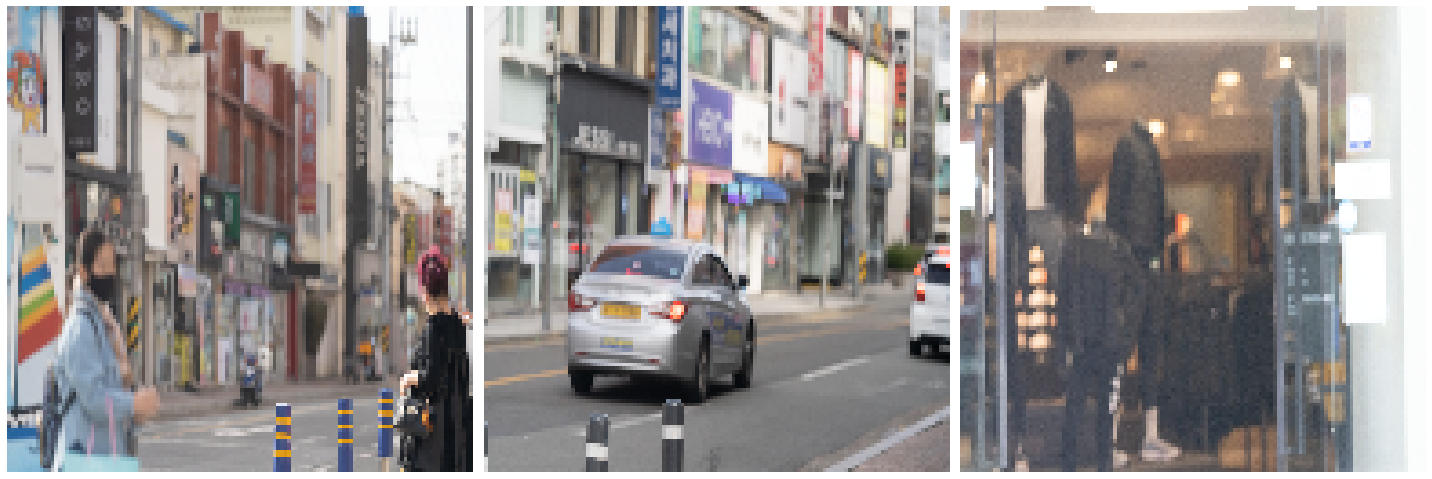

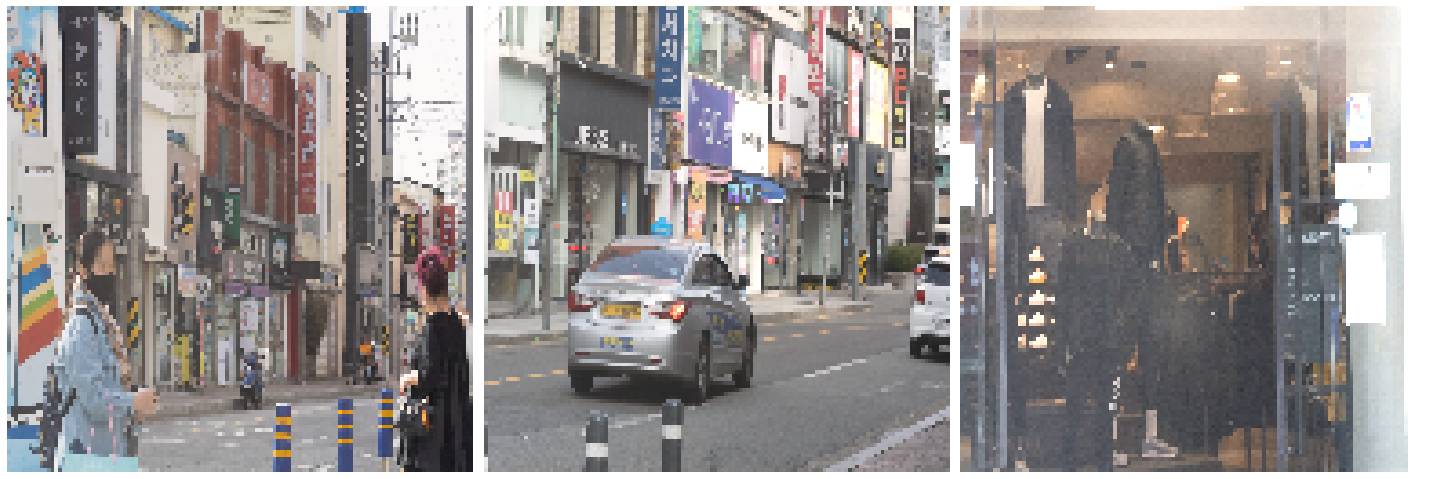

In [25]:
xx,yy=train[0]
plotImages(xx)
plotImages(yy)

In [8]:
# xx[50]

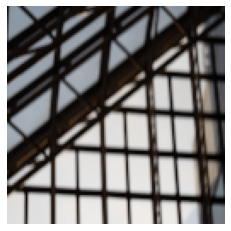

In [9]:
coba = xx[49]
plt.imshow(coba)
plt.axis('off')
plt.show()

# Model Building Autoencoder

In [10]:
def conv_operation(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def conv_transpose_operation(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deblurring_autoencoder():
   dae_inputs = Input(shape=(256,256,3), name='dae_input')
   conv_block1 = conv_operation(dae_inputs, 64, 3)
   conv_block2 = conv_operation(conv_block1, 128, 3)
   conv_block3 = conv_operation(conv_block2, 256, 3)
   conv_block4 = conv_operation(conv_block3, 512, 3)
   
   conv_block5 = conv_operation(conv_block4, 512, 3, 1)

   deconv_block1 = conv_transpose_operation(conv_block5, 512,3)
   merge1 = Concatenate()([conv_block3,deconv_block1])
   deconv_block2 = conv_transpose_operation(merge1, 256, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = conv_transpose_operation(merge2, 128, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = conv_transpose_operation(merge3, 64, 3)

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3,padding='same')(deconv_block4)

#    dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   
   return Model(dae_inputs, final_deconv, name='dae')

In [11]:
model= deblurring_autoencoder()

In [12]:
model.summary()

Model: "dae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dae_input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['dae_input[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                

In [13]:
opt=Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

In [14]:
callbacks=[
    ModelCheckpoint('deblur.h5',verbose=1,save_best_only=True,save_weights_only=True)
]

# Modelling

In [15]:
start = time.time()
model.fit(
    train,
    epochs=300,
    verbose=1,
    callbacks=callbacks
)
end = time.time()

Epoch 1/300
1/1 [==============================] - 64s 64s/step - loss: 0.8312 - mae: 0.7047
Epoch 2/300
1/1 [==============================] - 60s 60s/step - loss: 1.1136 - mae: 0.8027
Epoch 3/300
1/1 [==============================] - 59s 59s/step - loss: 0.3600 - mae: 0.4547
Epoch 4/300
1/1 [==============================] - 60s 60s/step - loss: 0.2088 - mae: 0.3491
Epoch 5/300
1/1 [==============================] - 60s 60s/step - loss: 0.1678 - mae: 0.3174
Epoch 6/300
1/1 [==============================] - 61s 61s/step - loss: 0.1398 - mae: 0.2882
Epoch 7/300
1/1 [==============================] - 59s 59s/step - loss: 0.1149 - mae: 0.2607
Epoch 8/300
1/1 [==============================] - 60s 60s/step - loss: 0.0919 - mae: 0.2305
Epoch 9/300
1/1 [==============================] - 60s 60s/step - loss: 0.0738 - mae: 0.2034
Epoch 10/300
1/1 [==============================] - 60s 60s/step - loss: 0.0636 - mae: 0.1873
Epoch 11/300
1/1 [==============================] - 60s 60s/step - lo

1/1 [==============================] - 59s 59s/step - loss: 0.0103 - mae: 0.0723
Epoch 68/300
1/1 [==============================] - 60s 60s/step - loss: 0.0102 - mae: 0.0720
Epoch 69/300
1/1 [==============================] - 61s 61s/step - loss: 0.0102 - mae: 0.0717
Epoch 70/300
1/1 [==============================] - 59s 59s/step - loss: 0.0101 - mae: 0.0715
Epoch 71/300
1/1 [==============================] - 59s 59s/step - loss: 0.0101 - mae: 0.0713
Epoch 72/300
1/1 [==============================] - 59s 59s/step - loss: 0.0100 - mae: 0.0711
Epoch 73/300
1/1 [==============================] - 58s 58s/step - loss: 0.0099 - mae: 0.0708
Epoch 74/300
1/1 [==============================] - 60s 60s/step - loss: 0.0099 - mae: 0.0706
Epoch 75/300
1/1 [==============================] - 62s 62s/step - loss: 0.0098 - mae: 0.0703
Epoch 76/300
1/1 [==============================] - 63s 63s/step - loss: 0.0098 - mae: 0.0701
Epoch 77/300
1/1 [==============================] - 62s 62s/step - loss: 

Epoch 133/300
1/1 [==============================] - 29s 29s/step - loss: 0.0080 - mae: 0.0624
Epoch 134/300
1/1 [==============================] - 28s 28s/step - loss: 0.0080 - mae: 0.0623
Epoch 135/300
1/1 [==============================] - 28s 28s/step - loss: 0.0080 - mae: 0.0622
Epoch 136/300
1/1 [==============================] - 29s 29s/step - loss: 0.0080 - mae: 0.0622
Epoch 137/300
1/1 [==============================] - 30s 30s/step - loss: 0.0079 - mae: 0.0621
Epoch 138/300
1/1 [==============================] - 29s 29s/step - loss: 0.0079 - mae: 0.0620
Epoch 139/300
1/1 [==============================] - 29s 29s/step - loss: 0.0079 - mae: 0.0619
Epoch 140/300
1/1 [==============================] - 29s 29s/step - loss: 0.0079 - mae: 0.0618
Epoch 141/300
1/1 [==============================] - 32s 32s/step - loss: 0.0079 - mae: 0.0617
Epoch 142/300
1/1 [==============================] - 30s 30s/step - loss: 0.0079 - mae: 0.0617
Epoch 143/300
1/1 [==============================]

Epoch 166/300
1/1 [==============================] - 29s 29s/step - loss: 0.0075 - mae: 0.0600
Epoch 167/300
1/1 [==============================] - 29s 29s/step - loss: 0.0075 - mae: 0.0599
Epoch 168/300
1/1 [==============================] - 29s 29s/step - loss: 0.0075 - mae: 0.0598
Epoch 169/300
1/1 [==============================] - 29s 29s/step - loss: 0.0075 - mae: 0.0598
Epoch 170/300
1/1 [==============================] - 28s 28s/step - loss: 0.0075 - mae: 0.0597
Epoch 171/300
1/1 [==============================] - 29s 29s/step - loss: 0.0075 - mae: 0.0597
Epoch 172/300
1/1 [==============================] - 29s 29s/step - loss: 0.0074 - mae: 0.0596
Epoch 173/300
1/1 [==============================] - 29s 29s/step - loss: 0.0074 - mae: 0.0595
Epoch 174/300
1/1 [==============================] - 29s 29s/step - loss: 0.0074 - mae: 0.0595
Epoch 175/300
1/1 [==============================] - 29s 29s/step - loss: 0.0074 - mae: 0.0594
Epoch 176/300
1/1 [==============================]

Epoch 199/300
1/1 [==============================] - 29s 29s/step - loss: 0.0072 - mae: 0.0582
Epoch 200/300
1/1 [==============================] - 29s 29s/step - loss: 0.0072 - mae: 0.0581
Epoch 201/300
1/1 [==============================] - 28s 28s/step - loss: 0.0071 - mae: 0.0581
Epoch 202/300
1/1 [==============================] - 29s 29s/step - loss: 0.0071 - mae: 0.0580
Epoch 203/300
1/1 [==============================] - 31s 31s/step - loss: 0.0071 - mae: 0.0580
Epoch 204/300
1/1 [==============================] - 31s 31s/step - loss: 0.0071 - mae: 0.0580
Epoch 205/300
1/1 [==============================] - 29s 29s/step - loss: 0.0071 - mae: 0.0579
Epoch 206/300
1/1 [==============================] - 29s 29s/step - loss: 0.0071 - mae: 0.0579
Epoch 207/300
1/1 [==============================] - 29s 29s/step - loss: 0.0071 - mae: 0.0578
Epoch 208/300
1/1 [==============================] - 29s 29s/step - loss: 0.0071 - mae: 0.0578
Epoch 209/300
1/1 [==============================]

Epoch 232/300
1/1 [==============================] - 29s 29s/step - loss: 0.0069 - mae: 0.0568
Epoch 233/300
1/1 [==============================] - 29s 29s/step - loss: 0.0069 - mae: 0.0568
Epoch 234/300
1/1 [==============================] - 30s 30s/step - loss: 0.0069 - mae: 0.0568
Epoch 235/300
1/1 [==============================] - 29s 29s/step - loss: 0.0069 - mae: 0.0567
Epoch 236/300
1/1 [==============================] - 29s 29s/step - loss: 0.0069 - mae: 0.0567
Epoch 237/300
1/1 [==============================] - 29s 29s/step - loss: 0.0069 - mae: 0.0567
Epoch 238/300
1/1 [==============================] - 30s 30s/step - loss: 0.0069 - mae: 0.0566
Epoch 239/300
1/1 [==============================] - 29s 29s/step - loss: 0.0069 - mae: 0.0566
Epoch 240/300
1/1 [==============================] - 30s 30s/step - loss: 0.0069 - mae: 0.0566
Epoch 241/300
1/1 [==============================] - 29s 29s/step - loss: 0.0068 - mae: 0.0565
Epoch 242/300
1/1 [==============================]

Epoch 265/300
1/1 [==============================] - 29s 29s/step - loss: 0.0067 - mae: 0.0558
Epoch 266/300
1/1 [==============================] - 48s 48s/step - loss: 0.0067 - mae: 0.0557
Epoch 267/300
1/1 [==============================] - 62s 62s/step - loss: 0.0067 - mae: 0.0557
Epoch 268/300
1/1 [==============================] - 59s 59s/step - loss: 0.0067 - mae: 0.0557
Epoch 269/300
1/1 [==============================] - 60s 60s/step - loss: 0.0067 - mae: 0.0557
Epoch 270/300
1/1 [==============================] - 61s 61s/step - loss: 0.0067 - mae: 0.0556
Epoch 271/300
1/1 [==============================] - 64s 64s/step - loss: 0.0067 - mae: 0.0556
Epoch 272/300
1/1 [==============================] - 60s 60s/step - loss: 0.0067 - mae: 0.0556
Epoch 273/300
1/1 [==============================] - 60s 60s/step - loss: 0.0067 - mae: 0.0555
Epoch 274/300
1/1 [==============================] - 62s 62s/step - loss: 0.0067 - mae: 0.0555
Epoch 275/300
1/1 [==============================]

Epoch 298/300
1/1 [==============================] - 60s 60s/step - loss: 0.0065 - mae: 0.0549
Epoch 299/300
1/1 [==============================] - 60s 60s/step - loss: 0.0065 - mae: 0.0549
Epoch 300/300
1/1 [==============================] - 61s 61s/step - loss: 0.0065 - mae: 0.0548


In [27]:
model=keras.models.load_model('best_model/')

In [28]:
prediction= model.predict(xx)

# Result

In [ ]:
plotImages(xx)
plotImages(prediction)

In [19]:
prediction[0]

array([[[ 0.53785425,  0.3990895 ,  0.30442154],
        [ 0.57541424,  0.50078964,  0.48041028],
        [ 0.5787535 ,  0.5605295 ,  0.5233635 ],
        ...,
        [ 0.56609875,  0.5407489 ,  0.6159117 ],
        [ 0.5849983 ,  0.513463  ,  0.53490525],
        [ 0.28751943,  0.4570162 ,  0.41916013]],

       [[ 0.4350651 ,  0.580172  ,  0.61471254],
        [ 0.62599564,  0.51609075,  0.5216071 ],
        [ 0.62000126,  0.5968741 ,  0.53107613],
        ...,
        [ 0.6837364 ,  0.6430152 ,  0.6365405 ],
        [ 0.50412714,  0.4991917 ,  0.50863975],
        [ 0.51102597,  0.3903358 ,  0.3721163 ]],

       [[ 0.58621484,  0.51739496,  0.5532863 ],
        [ 0.5500589 ,  0.5795741 ,  0.5719496 ],
        [ 0.59969056,  0.58465284,  0.5379526 ],
        ...,
        [ 0.61623204,  0.60352856,  0.6680754 ],
        [ 0.5219516 ,  0.5080486 ,  0.4610166 ],
        [ 0.3522715 ,  0.39806703,  0.43313736]],

       ...,

       [[ 0.5089329 ,  0.5344708 ,  0.5956472 ],
        [ 0

In [20]:
yy[0]

array([[[0.72941176, 0.72941176, 0.75294118],
        [0.42352941, 0.56078431, 0.6745098 ],
        [0.74901961, 0.7372549 , 0.75294118],
        ...,
        [0.98431373, 0.97647059, 0.97647059],
        [0.56862745, 0.57647059, 0.61176471],
        [0.4745098 , 0.46666667, 0.48627451]],

       [[0.43921569, 0.56862745, 0.67843137],
        [0.76470588, 0.75294118, 0.76470588],
        [0.76470588, 0.75294118, 0.76078431],
        ...,
        [0.98431373, 0.97647059, 0.97647059],
        [0.56862745, 0.57647059, 0.60784314],
        [0.4627451 , 0.45490196, 0.47058824]],

       [[0.76078431, 0.74117647, 0.74901961],
        [0.76862745, 0.75686275, 0.76470588],
        [0.76862745, 0.75294118, 0.76078431],
        ...,
        [0.98431373, 0.97647059, 0.97647059],
        [0.56862745, 0.58039216, 0.61568627],
        [0.47058824, 0.45882353, 0.47843137]],

       ...,

       [[0.59607843, 0.7372549 , 0.81176471],
        [0.61568627, 0.75294118, 0.82745098],
        [0.59607843, 0

In [22]:
time = end-start
time

12376.650587558746

In [29]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(result, gt):
    gray_ori = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)
    gray_dbl = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    
    return ssim(gray_ori, gray_dbl)

print(calculate_ssim(prediction[0],yy[0]))
print(calculate_ssim(prediction[1],yy[1]))
print(calculate_ssim(prediction[2],yy[2]))
print(calculate_ssim(prediction[3],yy[3]))
print(calculate_ssim(prediction[4],yy[4]))
print(calculate_ssim(prediction[5],yy[5]))
print(calculate_ssim(prediction[6],yy[6]))
print(calculate_ssim(prediction[7],yy[7]))
print(calculate_ssim(prediction[8],yy[8]))
print(calculate_ssim(prediction[9],yy[9]))

0.5991906854163295
0.6427050211051625
0.7472727134220214
0.6171795954366026
0.5268556927816852
0.5823741665210403
0.6318809898176359
0.5630526838413176
0.6516795805493106
0.650599831403599


In [34]:
def plot(image,title) : 
    plt.figure(figsize=(10, 6), dpi=80)
    plt.imshow(image)
    plt.title(title)
    plt.show()

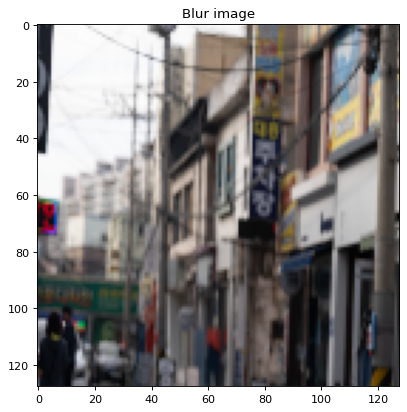

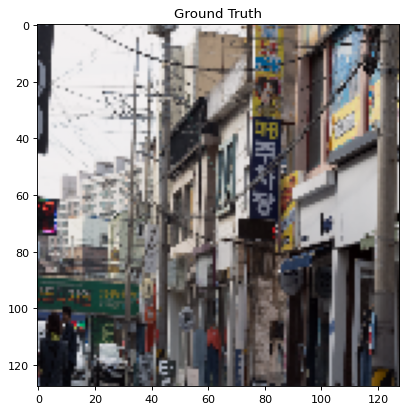

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


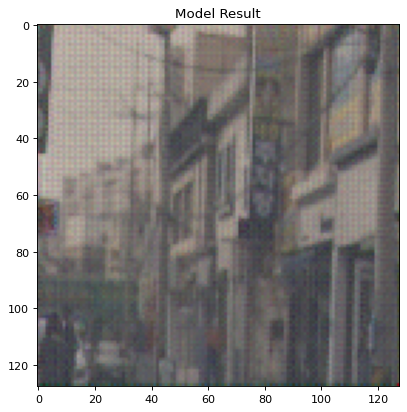

In [40]:
plot(xx[4],'Blur image')
plot(yy[4],'Ground Truth')
plot(prediction[4],'Model Result')

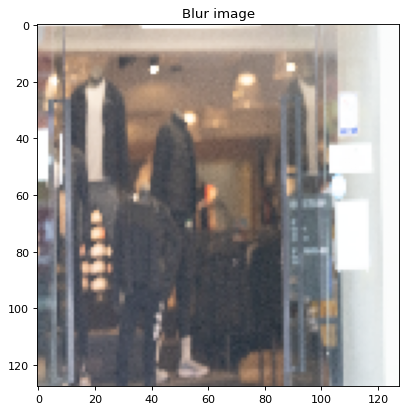

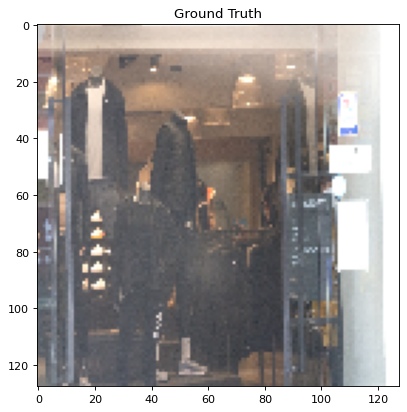

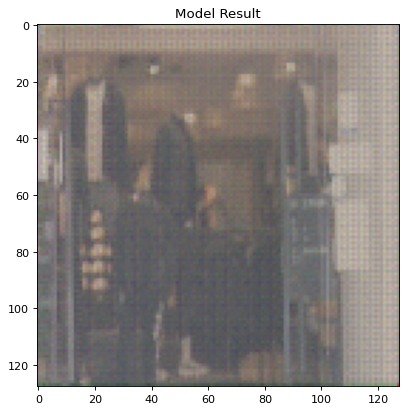

In [38]:
plot(xx[2],'Blur image')
plot(yy[2],'Ground Truth')
plot(prediction[2],'Model Result')

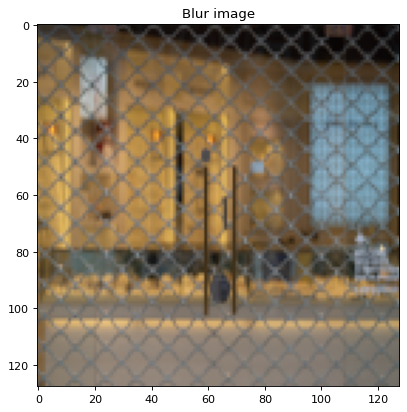

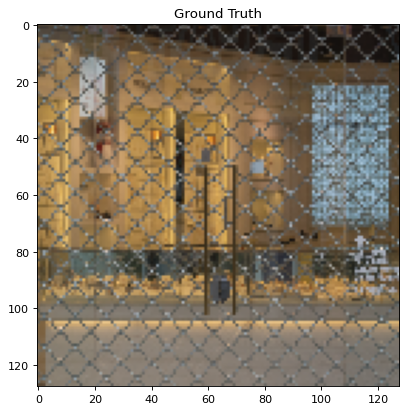

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


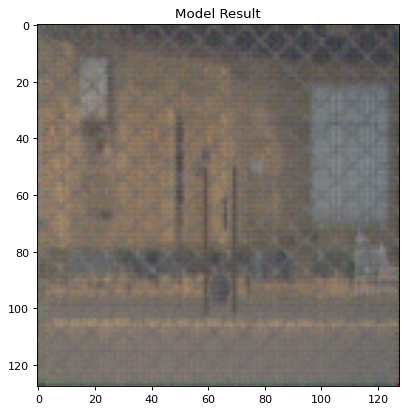

In [39]:
plot(xx[7],'Blur image')
plot(yy[7],'Ground Truth')
plot(prediction[7],'Model Result')